In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# 有蟲 所以加這行
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 設置中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'將使用 {device} 進行計算')

def set_seed(seed):
    """
    設定所有隨機種子以確保結果可重現。
    """
    # 設定 Python 內建的隨機亂數
    random.seed(seed)
    
    # 設定 NumPy 的隨機種子
    np.random.seed(seed)
    
    # 設定 PyTorch 的隨機種子 (CPU)
    torch.manual_seed(seed)
    
    # 如果您使用 GPU (CUDA)
    if torch.cuda.is_available():
        # 為當前的 GPU 設定種子
        torch.cuda.manual_seed(seed)
        
        # 為所有的 GPU 設定種子 (如果您有多個 GPU)
        torch.cuda.manual_seed_all(seed)
        
        # 確保 CUDA 使用確定性的演算法，這可能會犧牲一點效能
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED_VALUE = 11
set_seed(SEED_VALUE)


將使用 cuda 進行計算


In [10]:
# 定義 Runge 函數
def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def runge_derivative(x):
    """計算 Runge 函數的真實導數"""
    return -50.0 * x / ((1.0 + 25.0 * x**2)**2)

# 生成數據
x_np = np.linspace(-1, 1, 1000, dtype=np.float32)
y_np = runge_function(x_np)

# 將 NumPy array 轉換為 PyTorch Tensor
# .view(-1, 1) 是為了將數據塑造成 (樣本數, 特徵數) 的形狀，符合神經網路輸入要求
x_tensor = torch.from_numpy(x_np).view(-1, 1)
y_tensor = torch.from_numpy(y_np).view(-1, 1)

y_prime_np = runge_derivative(x_np)
y_prime_tensor = torch.from_numpy(y_prime_np).view(-1, 1)

# 隨機打亂數據索引
indices = torch.randperm(x_tensor.shape[0])

# 按 8:2 比例分割訓練集和驗證集
train_indices = indices[:800]
val_indices = indices[800:]

x_train, y_train, y_prime_train = x_tensor[train_indices], y_tensor[train_indices], y_prime_tensor[train_indices]
x_val, y_val, y_prime_val = x_tensor[val_indices], y_tensor[val_indices], y_prime_tensor[val_indices]

# 使用 GPU (如果可用)
x_train, y_train, y_prime_train = x_train.to(device), y_train.to(device), y_prime_train.to(device)
x_val, y_val, y_prime_val = x_val.to(device), y_val.to(device), y_prime_val.to(device)

In [11]:


class RungeNet(nn.Module):
    def __init__(self):
        super(RungeNet, self).__init__()
        # 定義網路層：1 -> 64 -> 64 -> 1
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

In [12]:

# 實例化模型並將其轉移到計算設備
model = RungeNet().to(device)
print("模型架構:")
print(model)


# 設定超參數
learning_rate = 0.001
epochs = 1000

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses_func = []
train_losses_de = []
val_losses_func = []
val_losses_de = []

print("\n開始訓練...")

模型架構:
RungeNet(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

開始訓練...


In [13]:
# 訓練
print("\n開始訓練 (包含導數)...")

# 訓練
for epoch in range(epochs):
    # --- 訓練模式 ---
    model.train()

    # 為了計算對輸入 x 的梯度，我們需要設定 x_train.requires_grad = True
    x_train.requires_grad_(True)

    # 1. 計算函數值的預測
    y_pred = model(x_train)
    
    # 2. 計算模型輸出的導數 (y_pred 對 x_train 的梯度)
    y_prime_pred = torch.autograd.grad(
        y_pred, x_train, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True  # 允許創建更高階的導數圖，對於優化器是必要的
    )[0]
    
    # 計算損失
    loss_f = criterion(y_pred, y_train)          # 函數值的損失
    loss_df = criterion(y_prime_pred, y_prime_train) # 導數的損失
    total_loss = loss_f + loss_df                # 總損失是兩者之和
    
    # 反向傳播與優化 (基於 total_loss)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 關閉 x_train 的梯度計算，以免影響下一輪
    x_train.requires_grad_(False)
    
    train_losses_func.append(loss_f.item())
    train_losses_de.append(loss_df.item())
    
    # --- 驗證模式 ---
    model.eval()
    
    # 為了計算導數，需要對 x_val 開啟梯度計算
    x_val.requires_grad_(True)
    
    # 前向傳播
    y_val_pred = model(x_val)
    
    y_prime_val_pred = torch.autograd.grad(y_val_pred, x_val, grad_outputs=torch.ones_like(y_val_pred))[0]

    val_loss_f = criterion(y_val_pred, y_val)
    val_loss_df = criterion(y_prime_val_pred, y_prime_val)
    total_val_loss = val_loss_f + val_loss_df

    x_val.requires_grad_(False)
    val_losses_func.append(val_loss_f.item())
    val_losses_de.append(val_loss_df.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], 總訓練損失: {total_loss.item():.6f} (函數損失: {loss_f.item():.6f}, 導數損失: {loss_df.item():.6f})')

print("訓練完成！")



開始訓練 (包含導數)...
Epoch [100/1000], 總訓練損失: 0.343252 (函數損失: 0.002368, 導數損失: 0.340884)
Epoch [200/1000], 總訓練損失: 0.006598 (函數損失: 0.000037, 導數損失: 0.006561)
Epoch [300/1000], 總訓練損失: 0.001644 (函數損失: 0.000009, 導數損失: 0.001635)
Epoch [400/1000], 總訓練損失: 0.000681 (函數損失: 0.000003, 導數損失: 0.000678)
Epoch [500/1000], 總訓練損失: 0.000384 (函數損失: 0.000002, 導數損失: 0.000382)
Epoch [600/1000], 總訓練損失: 0.000217 (函數損失: 0.000001, 導數損失: 0.000216)
Epoch [700/1000], 總訓練損失: 0.000124 (函數損失: 0.000001, 導數損失: 0.000123)
Epoch [800/1000], 總訓練損失: 0.000073 (函數損失: 0.000000, 導數損失: 0.000072)
Epoch [900/1000], 總訓練損失: 0.000044 (函數損失: 0.000000, 導數損失: 0.000044)
Epoch [1000/1000], 總訓練損失: 0.000028 (函數損失: 0.000000, 導數損失: 0.000028)
訓練完成！


In [14]:
print("\n評估模型...")
model.eval()

# 為了計算導數，需要開啟 x_val 的梯度需求
x_val.requires_grad_(True)

# 預測函數值與導數值
y_val_pred = model(x_val)
y_prime_val_pred = torch.autograd.grad(y_val_pred, x_val, grad_outputs=torch.ones_like(y_val_pred))[0]

# 關閉梯度計算
x_val.requires_grad_(False)

# 計算誤差
mse_error_f = criterion(y_val_pred, y_val).item()
max_error_f = torch.max(torch.abs(y_val_pred - y_val)).item()

mse_error_df = criterion(y_prime_val_pred, y_prime_val).item()
max_error_df = torch.max(torch.abs(y_prime_val_pred - y_prime_val)).item()

print(f"最終驗證集 - 函數 MSE: {mse_error_f:.6e}, 最大誤差: {max_error_f:.6e}")
print(f"最終驗證集 - 導數 MSE: {mse_error_df:.6e}, 最大誤差: {max_error_df:.6e}")


評估模型...
最終驗證集 - 函數 MSE: 7.246198e-08, 最大誤差: 8.139163e-04
最終驗證集 - 導數 MSE: 2.940738e-05, 最大誤差: 1.702309e-02


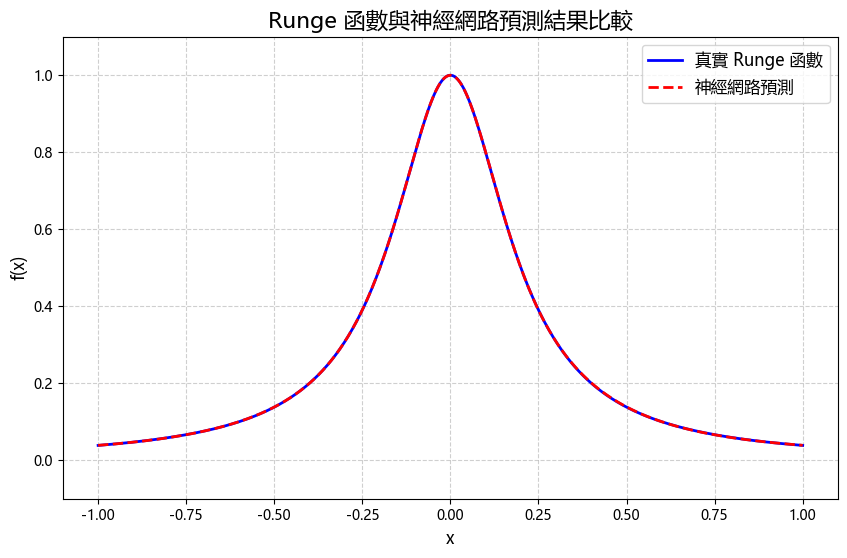

In [15]:
plt.figure(figsize=(10, 6))
model.eval()
with torch.no_grad():
    # 使用全部 1000 個點來繪製平滑的預測曲線
    x_plot = x_tensor.to(device)
    y_pred_plot = model(x_plot)

# 將 Tensor 從 GPU/CPU 轉回 CPU 上的 NumPy array 以便繪圖
plt.plot(x_np, y_np, 'b-', label='真實 Runge 函數', linewidth=2)
plt.plot(x_np, y_pred_plot.cpu().numpy(), 'r--', label='神經網路預測', linewidth=2)
plt.title('Runge 函數與神經網路預測結果比較', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)
plt.show()



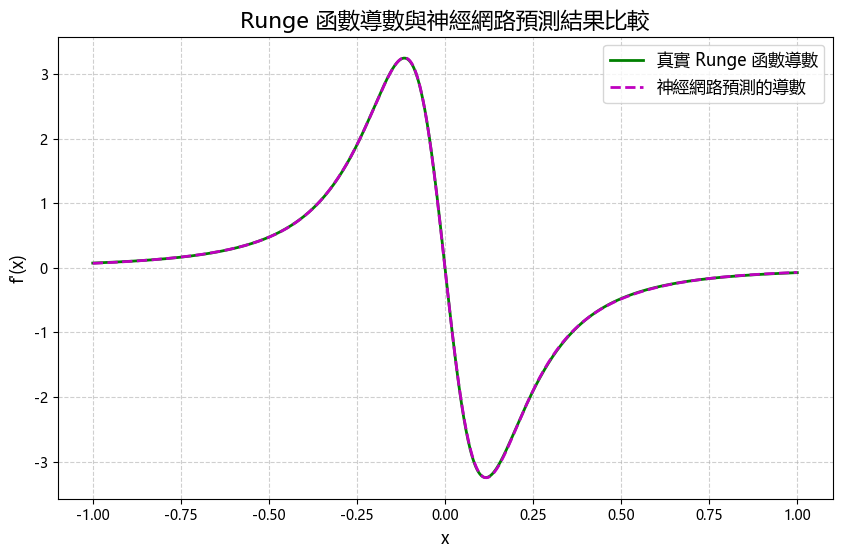

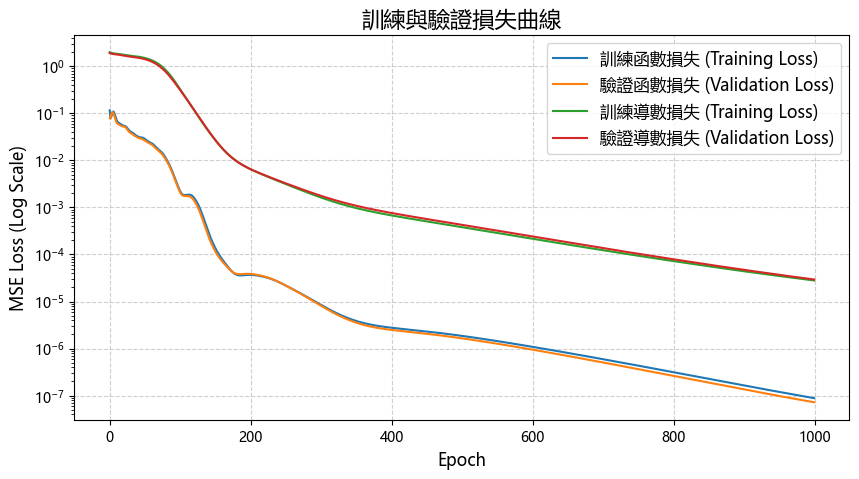

In [16]:
plt.figure(figsize=(10, 6))
model.eval()

# 為了計算梯度，需要開啟 x_tensor 的梯度需求
x_tensor.requires_grad_(True)
y_pred_plot = model(x_tensor.to(device))
y_prime_pred_plot = torch.autograd.grad(y_pred_plot, x_tensor, grad_outputs=torch.ones_like(y_pred_plot))[0]
x_tensor.requires_grad_(False)


# 將 Tensor 從 GPU/CPU 轉回 CPU 上的 NumPy array 以便繪圖
plt.plot(x_np, y_prime_np, 'g-', label='真實 Runge 函數導數', linewidth=2)
plt.plot(x_np, y_prime_pred_plot.cpu().detach().numpy(), 'm--', label='神經網路預測的導數', linewidth=2)
plt.title('Runge 函數導數與神經網路預測結果比較', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel("f'(x)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 繪製導數損失
plt.figure(figsize=(10, 5))
plt.plot(train_losses_func, label='訓練函數損失 (Training Loss)')
plt.plot(val_losses_func, label='驗證函數損失 (Validation Loss)')
plt.plot(train_losses_de, label='訓練導數損失 (Training Loss)')
plt.plot(val_losses_de, label='驗證導數損失 (Validation Loss)')
plt.yscale('log') # 使用對數尺度以便觀察損失的細微變化
plt.title('訓練與驗證損失曲線', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (Log Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
